In [1]:
# Load the "autoreload" extension. Prior to executing code, modules are reloaded. 
# There's no need to restart jupyter notebook if you modify code in the `src` directory.
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2


In [5]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

import bike_classifier_whisk_0_1_21

In [6]:
# This code is heavily adapted from Adrian's code on pyimagesearch
# Adrian Rosebrock, "COVID-19: Face Mask Detector with OpenCV, Keras/TensorFlow, and Deep Learning", PyImageSearch,
# https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/, accessed on 4 May 2020

In [7]:
################################################################
#### Import Images
################################################################

In [9]:
# grab the list of images in our dataset directory
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = list(paths.list_images(bike_classifier_whisk_0_1_21.project.data_dir / 'raw/Road')) + \
             list(paths.list_images(bike_classifier_whisk_0_1_21.project.data_dir / 'raw/Mountain'))
data = []
labels = []

[INFO] loading images...


In [11]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

/Users/adambarnhard/dev/whisk_testing/bike_classifier_whisk_0_1_21/venv/lib/python3.8/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [12]:
################################################################
#### Prep for Model Training
################################################################

In [13]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [14]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [15]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [16]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [17]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [18]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [19]:
################################################################
#### Model Training
################################################################

In [20]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [21]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
11/11 [==============================] - 10s 906ms/step - loss: 0.8094 - accuracy: 0.5710 - val_loss: 0.4672 - val_accuracy: 0.8681
Epoch 2/20
11/11 [==============================] - 10s 890ms/step - loss: 0.6900 - accuracy: 0.6084 - val_loss: 0.4019 - val_accuracy: 0.9011
Epoch 3/20
11/11 [==============================] - 9s 792ms/step - loss: 0.5255 - accuracy: 0.7530 - val_loss: 0.3654 - val_accuracy: 0.9121
Epoch 4/20
11/11 [==============================] - 9s 802ms/step - loss: 0.4694 - accuracy: 0.7741 - val_loss: 0.3276 - val_accuracy: 0.9231
Epoch 5/20
11/11 [==============================] - 10s 871ms/step - loss: 0.4805 - accuracy: 0.7380 - val_loss: 0.2968 - val_accuracy: 0.9231
Epoch 6/20
11/11 [==============================] - 10s 877ms/step - loss: 0.4019 - accuracy: 0.8102 - val_loss: 0.2737 - val_accuracy: 0.9231
Epoch 7/20
11/11 [==============================] - 10s 904ms/step - loss: 0.3548 - accuracy: 0.8343 - val_loss: 0.2566 

In [22]:
# serialize the model to disk
print("[INFO] saving bike classifier model...")
model.save(bike_classifier_whisk_0_1_21.project.artifacts_dir / 'bike_classification_model.model', save_format="h5")

[INFO] saving bike classifier model...


In [23]:
################################################################
#### Validation
################################################################

In [24]:
# If you've already trained the model, import here
#model = load_model('../models/bike_classification_model.model')

In [25]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [26]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [27]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

    Mountain       0.92      0.98      0.95        50
        Road       0.97      0.90      0.94        41

    accuracy                           0.95        91
   macro avg       0.95      0.94      0.94        91
weighted avg       0.95      0.95      0.94        91



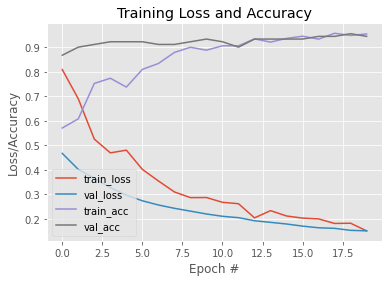

In [28]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()